<a href="https://colab.research.google.com/github/snoopyeom/Git-Test/blob/master/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer

In [36]:
#영화 리뷰 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7abbd6f5ab60>)

In [37]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [38]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [39]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [40]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [41]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [42]:
#시각화할 때 필요한 한글 폰트 다운
!apt-get -qq -y install fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

#세션 재시작
#import os
#os.kill(os.getpid(), 9)

#폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rc('font', family='NanumBarunGothic')

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [43]:
#결측치 확인
print(train_data['document'].isnull().sum())

5


In [44]:
#결측치 제거
train_data = train_data.dropna(how='any')

In [45]:
print(train_data['document'].isnull().sum())

0


In [46]:
# konlpy 패키지 설치
!pip install konlpy

#형태소 분석기로 Okt 사용
from konlpy.tag import Okt
okt = Okt()

In [47]:
#텍스트 단위와 그에 해당하는 품사 리스트화 시킨 후 리턴
sample = train_data.iloc[0,1]

print(okt.pos(sample))
print(okt.pos(sample, norm=True, stem=True))
print(okt.pos(sample, norm=True, join=True))

[('아', 'Exclamation'), ('더빙', 'Noun'), ('..', 'Punctuation'), ('진짜', 'Noun'), ('짜증나네요', 'Adjective'), ('목소리', 'Noun')]
[('아', 'Exclamation'), ('더빙', 'Noun'), ('..', 'Punctuation'), ('진짜', 'Noun'), ('짜증나다', 'Adjective'), ('목소리', 'Noun')]
['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나네요/Adjective', '목소리/Noun']


In [48]:
#위의 형식으로 파라미터 설정해 토큰화하는 함수 생성
def tokenize(doc):
  return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

In [49]:
#형태소 분석 결과
tokenize(train_data.iloc[0,1])

['아/Exclamation',
 '더빙/Noun',
 '../Punctuation',
 '진짜/Noun',
 '짜증나다/Adjective',
 '목소리/Noun']

In [50]:
#형태소 분석의 나쁜 예
tokenize(train_data.iloc[2,1])

['너/Modifier',
 '무재/Noun',
 '밓었/Noun',
 '다그/Noun',
 '래서/Noun',
 '보다/Verb',
 '추천/Noun',
 '한/Josa',
 '다/Adverb']

In [51]:
# 정규표현식 (한글을 제외한 특수문자)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

In [60]:
train_data['document'][:5]

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object

In [61]:
stopwords = set(['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'])

X_train = []

for sentence in train_data['document'][0:10000]:
    temp_X = okt.morphs(sentence, norm=True, stem=True)
    temp_X = list(filter(lambda x: x not in stopwords, temp_X))
    X_train.append(temp_X)

In [62]:
X_train[0:5]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [63]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=X_train, vector_size=300, window=3, min_count=5, workers=1)

word_vectors = model.wv

# 단어 인덱스를 얻기 위해 key_to_index 사용
vocabs = word_vectors.key_to_index.keys()

# 각 단어에 대한 벡터 리스트
word_vectors_list = [word_vectors[v] for v in vocabs]

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

In [65]:
# 단어와 2차원 x축의 값, y축의 값을 입력 받아 2차원 그래프를 그린다
def plot_2d_graph(vocabs, xs, ys):
  plt.figure(figsize=(25, 15))
  plt.scatter(xs, ys, marker = 'o')
  for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


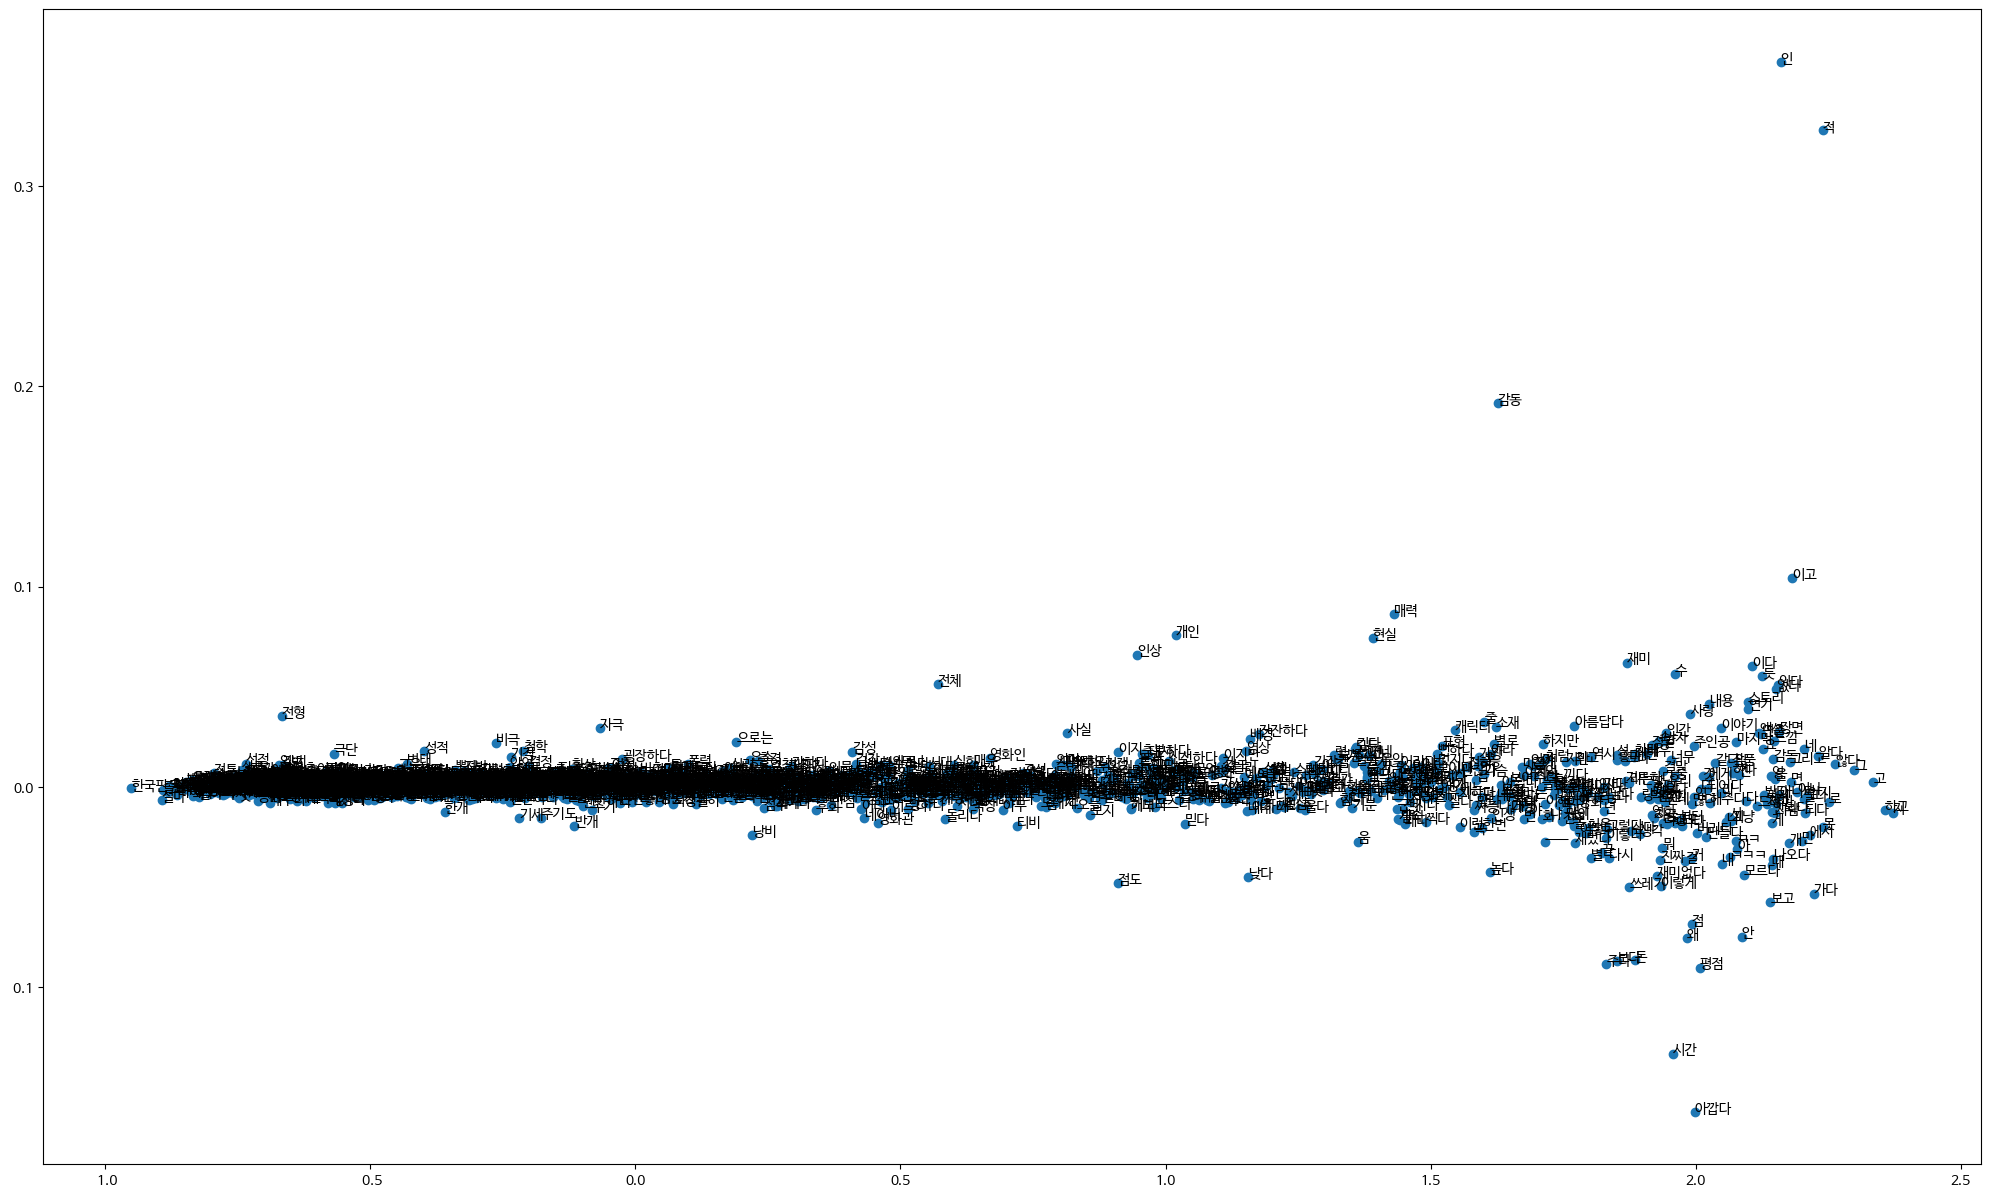

In [66]:
plot_2d_graph(vocabs, xs, ys)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


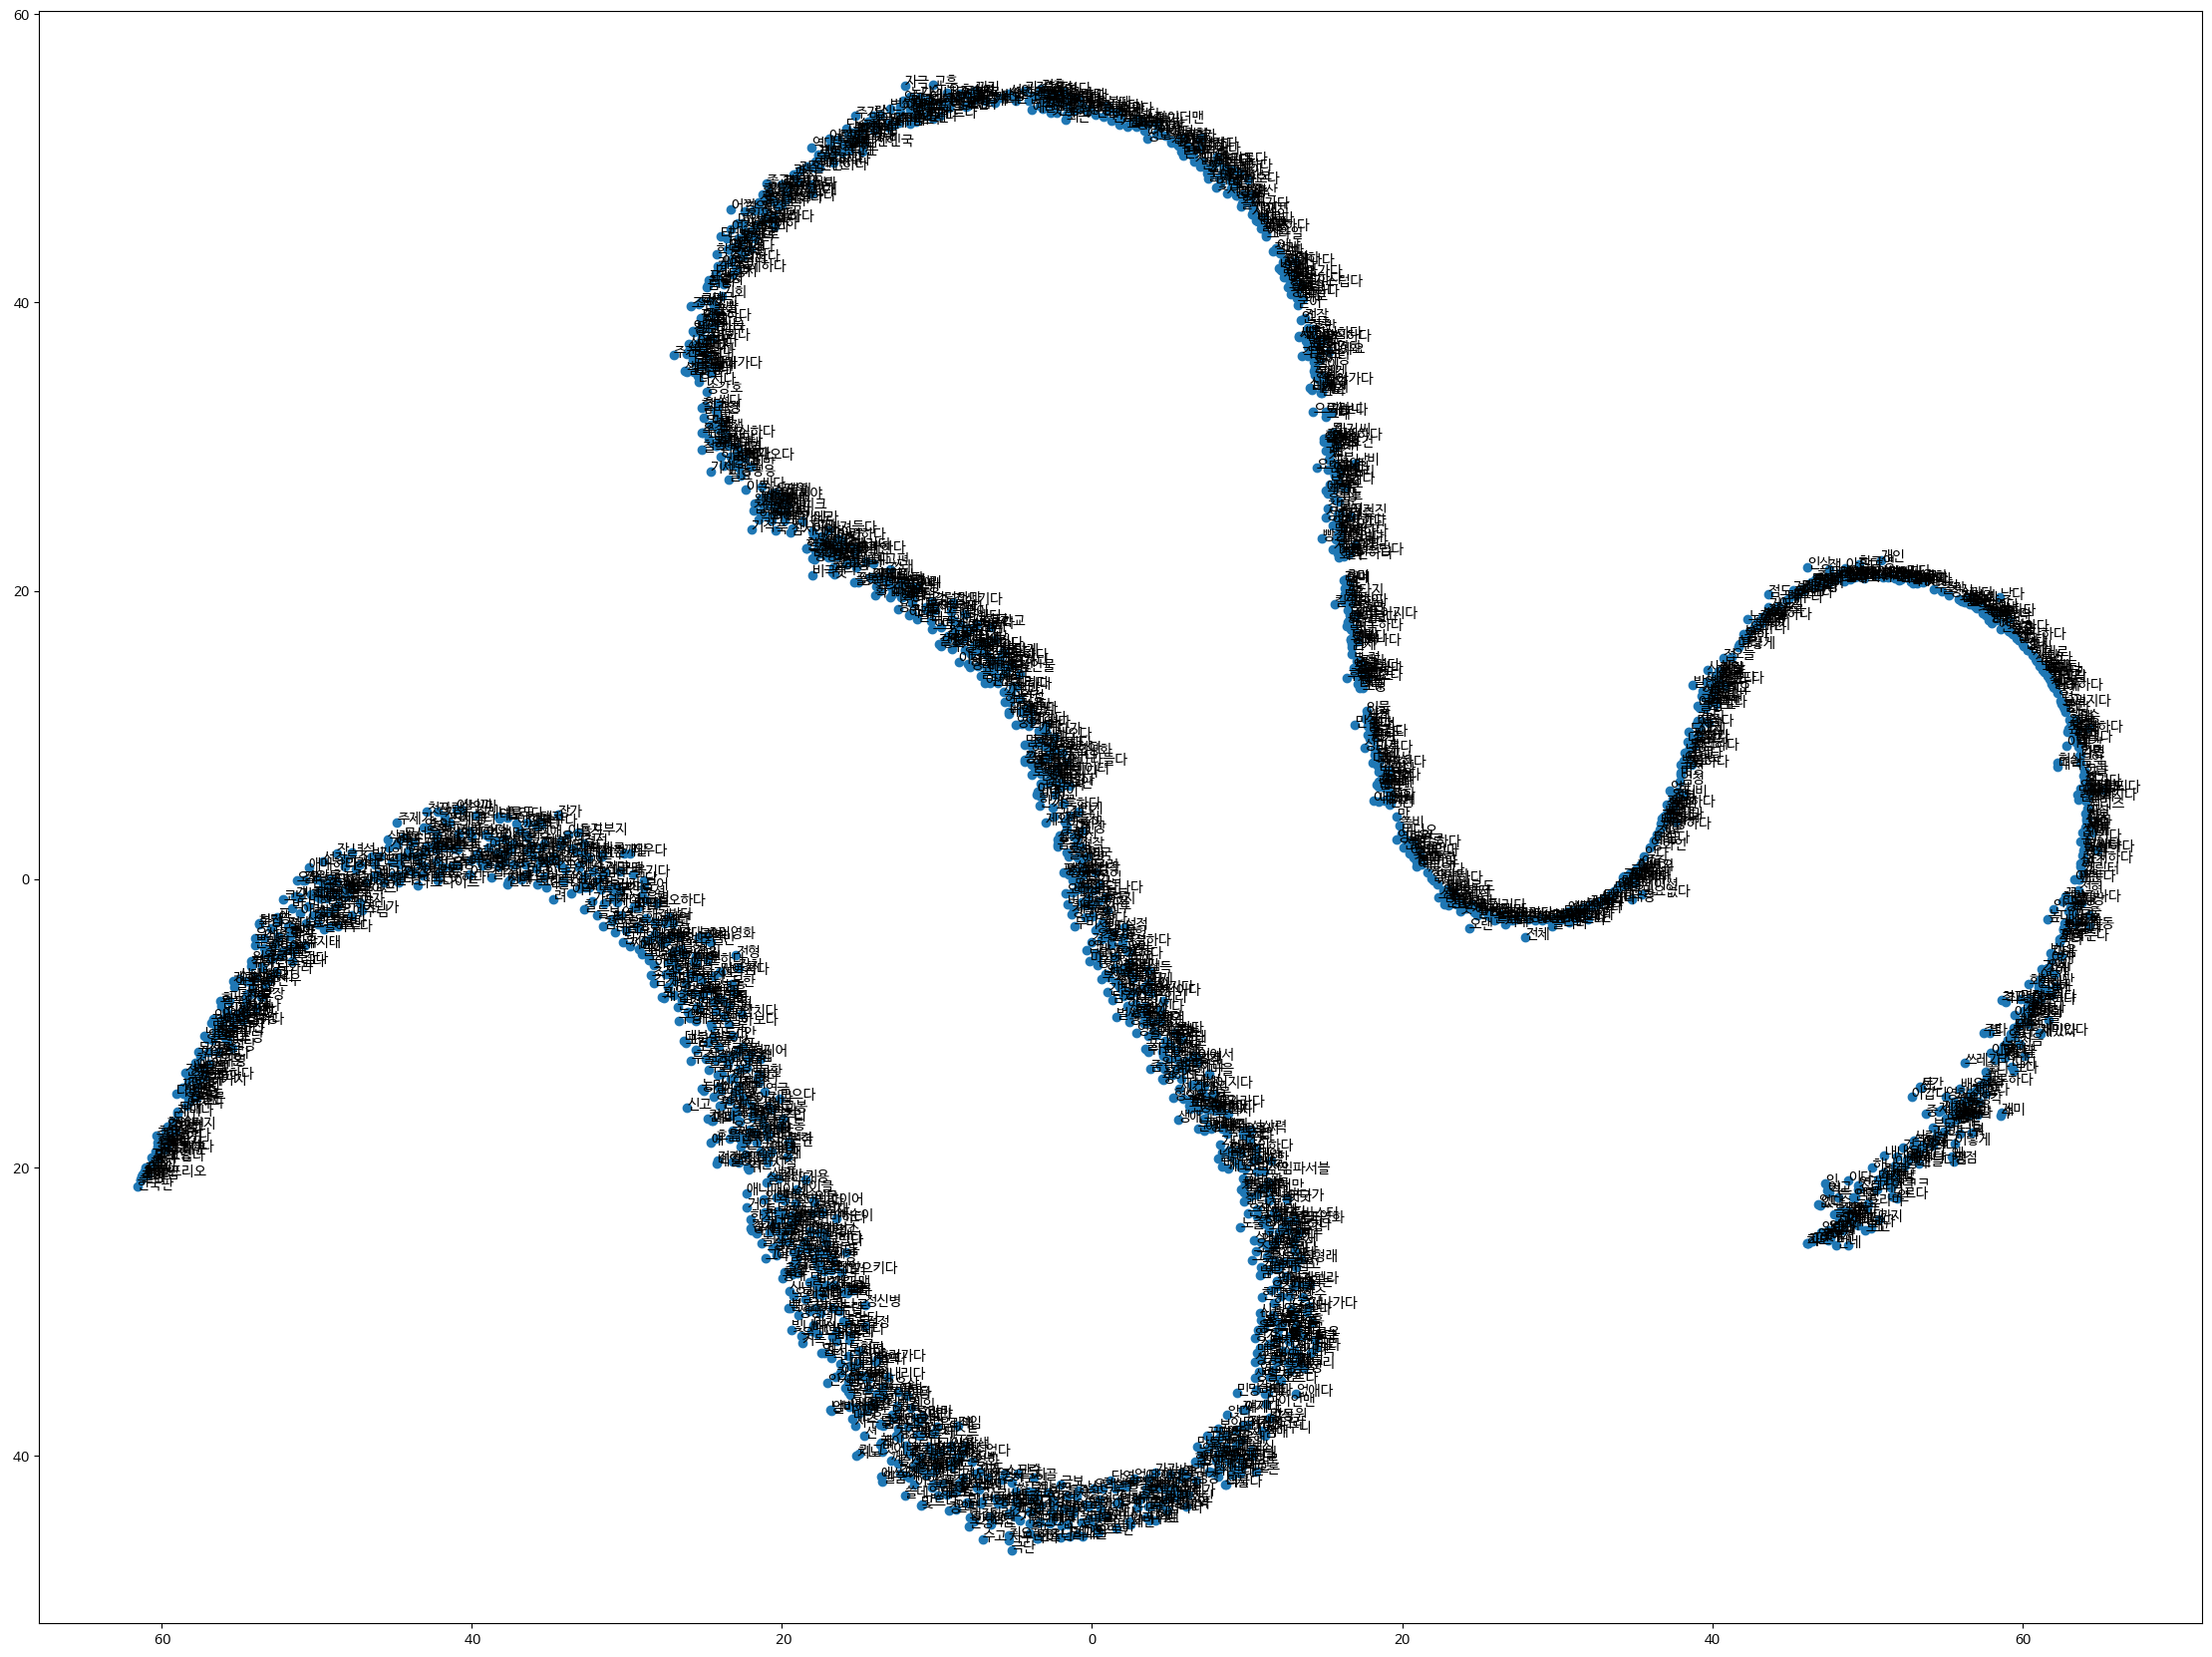

In [67]:
from sklearn.manifold import TSNE

# word_vectors_list를 NumPy 배열로 변환
word_vectors_array = np.array(word_vectors_list)

model2 = TSNE(learning_rate=100)
transformed = model2.fit_transform(word_vectors_array)

xs2 = transformed[:, 0]
ys2 = transformed[:, 1]

plt.figure(figsize=(28, 21))

plt.scatter(xs2, ys2)
for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs2[i], ys2[i]))

plt.show()